# **Pricing Test Analysis Report**

### **Introduction**

This Jupyter Notebook provides an in-depth analysis of a pricing test for Company XYZ, which currently sells its software for $39. 

The VP of Product initiated a test to assess the impact of increasing the price to $59. 

This test randomly assigned 66% of users to see the original price and 33% to see the higher price. 

The analysis aims to determine the optimal price point by comparing revenue and conversion metrics between these two price points.

### **Setup**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms

### **Data Loading and Preliminary Checks**

In [2]:
# Load the datasets
test_results_data = pd.read_csv("/Users/anhelinabaftalovska/Desktop/study/Pricing_Test/test_results.csv")
user_table_data = pd.read_csv("/Users/anhelinabaftalovska/Desktop/study/Pricing_Test/user_table.csv")

# Display the first few rows and check for missing values
display(test_results_data.head())
display(user_table_data.head())
display(test_results_data.isnull().sum())
display(user_table_data.isnull().sum())

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

### **Merge the Data**

Now that I've inspected both tables and verified that there are no missing values, I can merge **test_results** and **user_table** on the **user_id** column. This will combine the user information (location data) with the test results.


In [3]:
# Perform a left join to keep all rows from test_results
df = pd.merge(test_results_data, user_table_data, on='user_id', how='left')
display(df.head())

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [4]:
# Check for missing values again to see which users don't have location data
missing_values = df.isnull().sum()
"Missing values after left join:\n", missing_values

('Missing values after left join:\n',
 user_id                 0
 timestamp               0
 source                  0
 device                  0
 operative_system        0
 test                    0
 price                   0
 converted               0
 city                41184
 country             41184
 lat                 41184
 long                41184
 dtype: int64)

The result shows that 41,184 rows have missing values in the **city**, **country**, **lat**, and **long** columns, meaning these users were in the **test_results** table but not in the **user_table**. Let's check why we have so much missing values:

In [5]:
display(len(test_results_data))
display(len(user_table_data))

316800

275616

Based on the **len()** output, the key observation is that the **test_results** table has 316,800 entries, while the **user_table** has only 275,616 entries. This explains why you have so many missing values after the left join—there are 41,184 users in the **test_results** table who are not present in the **user_table**.

I will impute or ignore missing location data with "Unknown" or a default or exclude users with missing location data from location-specific analyses if needed.

### **Steps to Check Consistency Between test and price:**

In [6]:
# Group by test and price to check consistency
grouped = df.groupby(['test', 'price']).size()

# Display the result
grouped

test  price
0     39       202517
      59          210
1     39          155
      59       113918
dtype: int64


The groupby result reveals some inconsistencies between the test and price columns:

**test = 0** (control) should only see price = 39, but there are 210 users seeing price = 59, which is incorrect.
**test = 1** (test group) should only see price = 59, but 155 users are seeing price = 39, which is incorrect.

Given the relatively low number of affected users, the approach will be to exclude them from the analysis and proceed with the assessment.

In [7]:
# Exclude inconsistent rows where test group assignment doesn't match the price
df = df[~(((df['test'] == 0) & (df['price'] == 59)) | ((df['test'] == 1) & (df['price'] == 39)))]

# Group by test and price of the cleaned data
grouped = df.groupby(['test', 'price']).size()
grouped

test  price
0     39       202517
1     59       113918
dtype: int64

Let's now create the revenue variable, which is the main target of this challenge.

In [8]:
# Add a column for revenue (Price * Converted)
df['revenue'] = df['price'] * df['converted']
df['revenue'].describe()

count    316435.000000
mean          0.827083
std           6.179009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: revenue, dtype: float64

**Insights**

The majority of users are not converting, resulting in a low average revenue.
The high number of zero values in the revenue suggests a need for further analysis of conversion rates.

### **Exploratory Data Analysis**

**Conversion Rates and Revenue Analysis**

test
0    0.019900
1    0.015555
Name: converted, dtype: float64

test
0    0.776083
1    0.917748
Name: revenue, dtype: float64

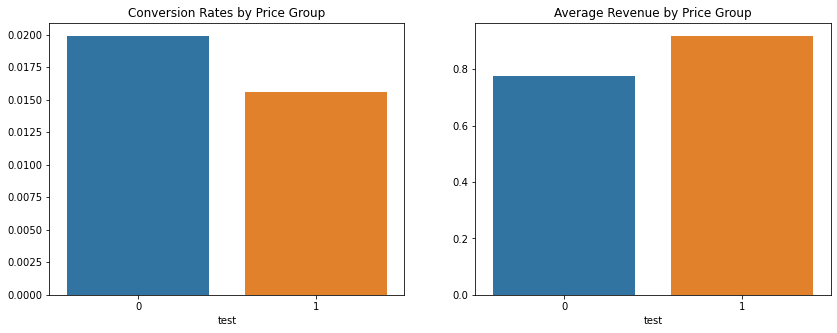

In [9]:
# Conversion rate
conversion_rate = df.groupby('test')['converted'].mean()

# Average Revenue Per User (ARPU)
arpu = df.groupby('test')['revenue'].mean()

display(conversion_rate, arpu)

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=conversion_rate.index, y=conversion_rate.values, ax=axes[0]).set_title('Conversion Rates by Price Group')
sns.barplot(x=arpu.index, y=arpu.values, ax=axes[1]).set_title('Average Revenue by Price Group')
plt.show()


**Insight:** Despite a drop in conversion rate, the average revenue per user (ARPU) is higher for the test group, suggesting that the price increase leads to more revenue per user.

To check if the difference in revenue per user between the two groups (test and control) is statistically significant, I can perform a t-test. This will help determine if the observed difference is due to random chance or if it's a meaningful difference between the groups.

### Statistical Significance Testing: T-Test

To determine whether the observed differences in revenue per user between the two pricing groups ($39 vs. $59) are statistically meaningful, we employ an independent samples t-test. This test evaluates whether the means of two independent groups are significantly different from one another.

**Hypotheses:**
- **Null Hypothesis (H0):** There is no difference in revenue per user between the two price points.
- **Alternative Hypothesis (H1):** There is a difference in revenue per user between the two price points.

A **p-value** less than 0.05 would lead us to reject the Null Hypothesis, indicating a statistically significant difference in revenue generated by the two pricing strategies, suggesting that the price change has a real effect, not due to random chance.


In [10]:
# Filter data for both groups
group_59 = df[df['test'] == 1]['revenue']
group_39 = df[df['test'] == 0]['revenue']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(group_59, group_39, equal_var=False)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion based on p-value
if p_value < 0.05:
    print("The difference in revenue per user between the two groups is statistically significant.")
else:
    print("The difference in revenue per user between the two groups is not statistically significant.")


T-statistic: 5.715224666463108
P-value: 1.0972577312420781e-08
The difference in revenue per user between the two groups is statistically significant.


In [11]:
# T-test for conversion rates
test_group = df[df['test'] == 1]['converted']
control_group = df[df['test'] == 0]['converted']

# Perform an independent t-test
t_stat_conv, p_value_conv = stats.ttest_ind(control_group,test_group,equal_var=False)

# Print the results
print(f"T-statistic: {t_stat_conv}")
print(f"P-value: {p_value_conv}")

# Conclusion based on p-value
if p_value < 0.05:
    print("The difference in conversion rates between the two groups is statistically significant.")
else:
    print("The difference in conversion rates between the two groups is not statistically significant.")


T-statistic: 9.044608417898376
P-value: 1.5119397664466364e-19
The difference in conversion rates between the two groups is statistically significant.


### **Segment Analysis**

Let's analyze revenue per user across different devices and traffic sources.

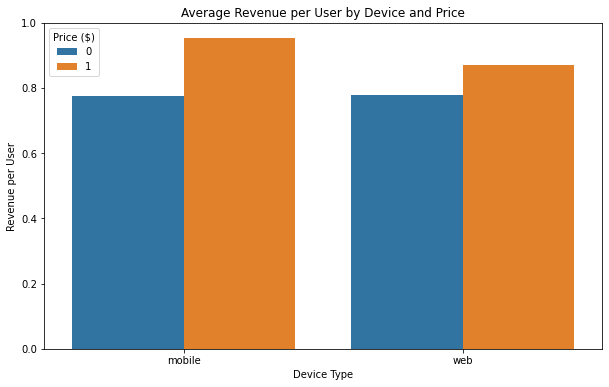

In [12]:
# Group by  'device' and test (price) and calculate mean conversion and revenue
segment_analysis = df.groupby(['device', 'test']).agg({'converted': 'mean', 'revenue': 'mean'}).reset_index()


# Plot revenue per user by device and price
plt.figure(figsize=(10, 6))
sns.barplot(x='device', y='revenue', hue='test', data=segment_analysis)
plt.title('Average Revenue per User by Device and Price')
plt.ylabel('Revenue per User')
plt.xlabel('Device Type')
plt.legend(title='Price ($)')
plt.show()

Devices (such as mobile and web) seem to show different responses to pricing, potentially indicating that certain device users are more price-sensitive.

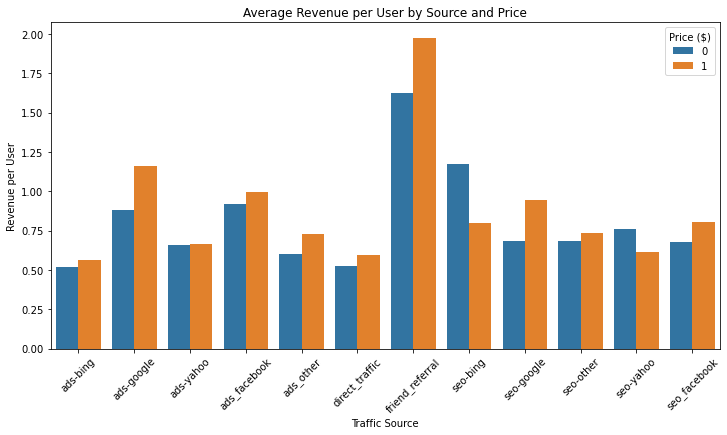

In [13]:
# Group by source and test (price) to calculate mean conversion and revenue
source_analysis = df.groupby(['source', 'test']).agg({'converted': 'mean', 'revenue': 'mean'}).reset_index()


# Plot revenue per user by source and price
plt.figure(figsize=(12, 6))
sns.barplot(x='source', y='revenue', hue='test', data=source_analysis)
plt.title('Average Revenue per User by Source and Price')
plt.ylabel('Revenue per User')
plt.xlabel('Traffic Source')
plt.legend(title='Price ($)')
plt.xticks(rotation=45)
plt.show()


There is a clear variation across traffic sources, suggesting that some acquisition channels may convert better with the lower price, while others might still perform well with the higher price.

<Figure size 720x432 with 0 Axes>

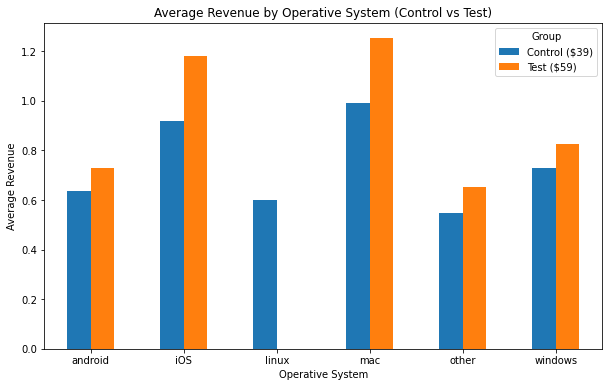

In [14]:
# Group by test and operative system to calculate mean revenue
operative_system_revenue = df.groupby(['operative_system', 'test'])['revenue'].mean().unstack()

# Plot revenue by operative system, comparing test (0: control, 1: test group)
plt.figure(figsize=(10, 6))
operative_system_revenue.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Average Revenue by Operative System (Control vs Test)')
plt.ylabel('Average Revenue')
plt.xlabel('Operative System')
plt.xticks(rotation=0)
plt.legend(['Control ($39)', 'Test ($59)'], title='Group', loc='best')
plt.show()


Looks like Linux has 0 convertion.
To investigate the Linux users further, let's break down the data to see how Linux users performed in both the test and control groups. Specifically, we can check the number of users in each group, their conversion rates, and revenue patterns.

In [15]:
# Filter data for Linux users only
linux_data = df[df['operative_system'] == 'linux']

# Analyze the number of users in each group (test and control) for Linux
linux_group_counts = linux_data.groupby('test').size()

# Analyze conversion rates for Linux users in both groups
linux_conversion_rate = linux_data.groupby('test')['converted'].mean()

# Analyze revenue for Linux users in both groups
linux_revenue = linux_data.groupby('test')['revenue'].mean()

# display the results
linux_group_counts, linux_conversion_rate,linux_revenue


(test
 0    2204
 1    1926
 dtype: int64,
 test
 0    0.015426
 1    0.000000
 Name: converted, dtype: float64,
 test
 0    0.601633
 1    0.000000
 Name: revenue, dtype: float64)

#### **Insights:**
**Price Sensitivity:** The 0% conversion rate for the test group ($59 price) indicates that Linux users are highly price-sensitive. Not a single user in the test group made a purchase, while 1.54% of Linux users converted at the $39 price.

**Revenue Impact:** The average revenue per Linux user is $0.60 in the control group but drops to $0.00 in the test group. This highlights that Linux users contribute significantly less revenue at the higher price point.


To check if the low conversion rate for Linux users could potentially be due to a bug in the data, let's first calculate the percentage of Linux users in the entire dataset. Then, if they represent a small percentage, we can redo the analysis excluding Linux users to see if the results significantly change.

### **Calculate the Percentage of Linux Users**

In [16]:
# Calculate total number of users
total_users = df.shape[0]

# Calculate total number of Linux users
total_linux_users = df[df['operative_system'] == 'linux'].shape[0]

# Calculate percentage of Linux users
linux_percentage = (total_linux_users / total_users) * 100
print(f"Percentage of Linux users: {linux_percentage:.2f}%")


Percentage of Linux users: 1.31%


**Redo the Analysis Without Linux Users (Revenue per User and Conversion Rate)**

In [17]:
# Filter out Linux users
df_no_linux = df[df['operative_system'] != 'linux']

# Calculate revenue per user for control and test groups without Linux users
revenue_per_user_no_linux = df_no_linux.groupby('test')['revenue'].mean()

# Print revenue per user without Linux users
print("Revenue per user without Linux users:")
print(revenue_per_user_no_linux)

# Calculate conversion rates for control and test groups without Linux users
conversion_rate_no_linux = df_no_linux.groupby('test')['converted'].mean()

# Print conversion rates without Linux users
print("\nConversion rates without Linux users:")
print(conversion_rate_no_linux)

# Perform a t-test on revenue per user between the control and test groups without Linux users
group_39_no_linux = df_no_linux[df_no_linux['test'] == 0]['revenue']
group_59_no_linux = df_no_linux[df_no_linux['test'] == 1]['revenue']

# Perform a t-test on revenue per user between the test and control groups without Linux users, swapping the groups
t_statistic_no_linux, p_value_no_linux = ttest_ind(group_59_no_linux, group_39_no_linux, equal_var=False)

# Display t-test results
print(f"\nT-statistic without Linux users: {t_statistic_no_linux}")
print(f"P-value without Linux users: {p_value_no_linux}")


Revenue per user without Linux users:
test
0    0.778002
1    0.933531
Name: revenue, dtype: float64

Conversion rates without Linux users:
test
0    0.019949
1    0.015823
Name: converted, dtype: float64

T-statistic without Linux users: 6.184240028400434
P-value without Linux users: 6.253458285742887e-10


The average **revenue per user** is still higher in the test group ($59 price)  than in the control group  ($39 price). This suggests that even without Linux users, the higher price point generates more revenue per user.

The **conversion rate** is slightly lower in the test group, as expected, but there is still a reasonable percentage of users willing to purchase at the higher price.

The **p-value** is still very low (well below 0.05), meaning the difference in revenue per user between the $39  and  $59 groups is **statistically significant**, even without Linux users.

<Figure size 720x432 with 0 Axes>

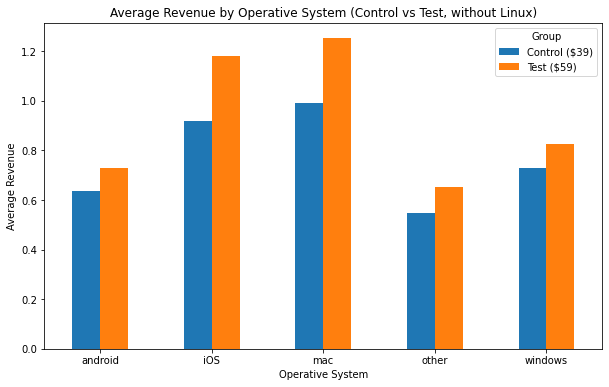

In [18]:
# Filter out Linux users
df_no_linux = df[df['operative_system'] != 'linux']

# Group by test and operative system to calculate mean revenue without Linux users
operative_system_revenue_no_linux = df_no_linux.groupby(['operative_system', 'test'])['revenue'].mean().unstack()

# Plot revenue by operative system, comparing test and control groups
plt.figure(figsize=(10, 6))
operative_system_revenue_no_linux.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Average Revenue by Operative System (Control vs Test, without Linux)')
plt.ylabel('Average Revenue')
plt.xlabel('Operative System')
plt.xticks(rotation=0)
plt.legend(['Control ($39)', 'Test ($59)'], title='Group', loc='best')
plt.show()


Since Linux users represent only 1.31% of the dataset and excluding them does not change the outcome substantially, it’s likely not a bug in the data but rather a genuine result that Linux users are more price-sensitive.

### **Get the Top 10 Cities by User Count**

Let's check the top 10 cities in terms of user base and analyze the revenue per user and conversion rates for these cities


In [19]:
# Get the top 10 cities by user count
top_10_cities = df_no_linux['city'].value_counts().head(10).index

# Filter data to include only the top 10 cities
df_top_10_cities = df_no_linux[df_no_linux['city'].isin(top_10_cities)]

# Display the top 10 cities
#display(f"Top 10 cities by user count:\n{top_10_cities}")
top_10_cities

Index(['New York', 'Chicago', 'Houston', 'San Antonio', 'Los Angeles',
       'San Jose', 'Indianapolis', 'Jacksonville', 'Philadelphia',
       'Las Vegas'],
      dtype='object')

In [20]:
# Group by city and test to calculate mean revenue and conversion rate
city_analysis = df_top_10_cities.groupby(['city', 'test']).agg({
    'revenue': 'mean',
    'converted': 'mean'
}).sort_values('city', ascending=False).reset_index()


# Print the revenue and conversion rates for top 10 cities
city_analysis


,city,test,revenue,converted
0,San Jose,1,1.155918,0.019592
1,San Jose,0,0.635362,0.016291
2,San Antonio,1,0.915274,0.015513
3,San Antonio,0,0.799514,0.020500
4,Philadelphia,1,0.747696,0.012673
5,Philadelphia,0,0.842593,0.021605
6,New York,1,0.890764,0.015098
7,New York,0,0.725615,0.018606
8,Los Angeles,1,0.918133,0.015562
9,Los Angeles,0,0.821524,0.021065


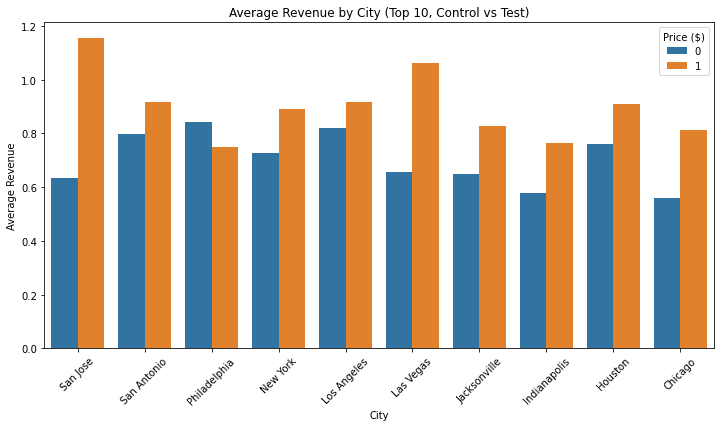

In [21]:
# Plot revenue per user for the top 10 cities, comparing control and test groups
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='revenue', hue='test', data=city_analysis, palette=['#1f77b4', '#ff7f0e'])
plt.title('Average Revenue by City (Top 10, Control vs Test)')
plt.ylabel('Average Revenue')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.legend(title='Price ($)')
plt.show()


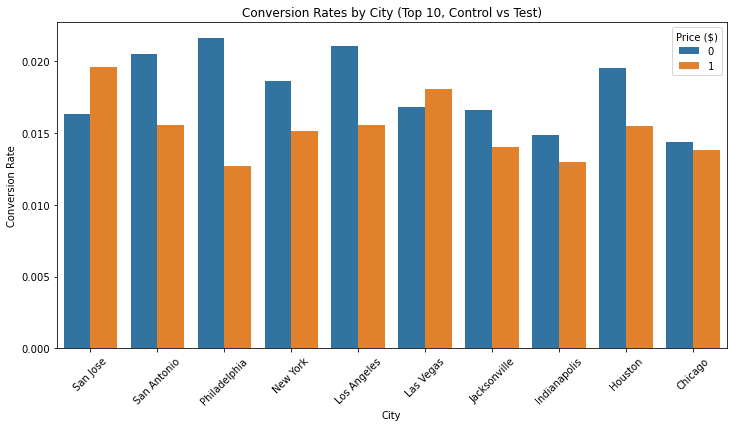

In [22]:
# Plot conversion rates for the top 10 cities, comparing control and test groups
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='converted', hue='test', data=city_analysis, palette=['#1f77b4', '#ff7f0e'])
plt.title('Conversion Rates by City (Top 10, Control vs Test)')
plt.ylabel('Conversion Rate')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.legend(title='Price ($)')
plt.show()


#### **Revenue per User:**

In most cities, the *test group ($59)* shows higher revenue per user compared to the *control group ($39)*. This indicates that despite a slight drop in conversion rates, users in these cities are generating more revenue at the higher price.
    
##### **Notable cities with the highest test group revenue:**
*San Jose:* $1.15 revenue per user (compared to $0.63 at $39).

*Las Vegas:* $1.06 revenue per user (compared to $0.65 at $39).

#### **Conversion Rates:**
In general, conversion rates are slightly lower in the test group, which is expected when the price is higher.


## After how many days you would have stopped the test?
To determine the appropriate duration for running a test, need to establish the minimum sample size required per group. This calculation hinges on defining the detectable effect size we aim to observe. 

Assuming a standard significance level of 0.05 and a power of 0.8, let's consider detecting a difference in conversion rates of approximately 33%, equivalent to a change from a 39% to a 59% conversion rate (1 - $39/$59). This means we aim to detect if the new conversion rate is about 66% of the old rate.


In [23]:
conversion_rate_control = test_results_data.query('test==0').converted.mean()
p1_and_p2 = sms.proportion_effectsize(conversion_rate_control, conversion_rate_control*39/59)
sample_size = round(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
print("The required sample size per group is ~", sample_size)

The required sample size per group is ~ 5548


In [24]:
#create a column that's week of the year
test_results_data['week_year'] = pd.to_datetime(test_results_data.timestamp.str.split(' ').str[0]).dt.strftime('%W')
#take avg count of users per week. We remove first and last week, just in case they don't include all 7 days
users_week = test_results_data['week_year'].value_counts().sort_index()
users_week = users_week.drop(users_week.index[[0,(users_week.shape[0]-1)]]).mean()
  
print("Avg number of users per week is:", round(users_week))

Avg number of users per week is: 24356


In [25]:
# Sample size required for both groups (control + test)
total_required_users = 5548 * 2  # 5548 users per group

# Avg number of users per week
users_per_week = 24356

# Calculate the number of weeks needed to get enough users
weeks_needed = total_required_users / users_per_week

print(f"The test would need to run for approximately {weeks_needed:.2f} weeks.")


The test would need to run for approximately 0.46 weeks.


The test could have been completed in just 3.2 days, assuming a consistent flow of users and no interruptions.

But it's advisable to run the test for at least two weeks to capture weekly patterns effectively. 

In terms of the percentage split between test and control groups, we need to determine the minimum percentage of users in the test group required to achieve the necessary sample size within two weeks.


In [26]:
# Required sample size per group
required_sample_size_per_group = 5548

# Total number of users in two weeks
total_users_in_two_weeks = 24356 * 2  # Avg users per week * 2 weeks

# Calculate the minimum percentage of users in the test group to reach the required sample size
min_percentage_test_group = (required_sample_size_per_group / total_users_in_two_weeks) * 100

# Print the result
print(f"The minimum percentage of users needed in the test group is ~{min_percentage_test_group:.2f}%.")


The minimum percentage of users needed in the test group is ~11.39%.


# **Conclusions and Recommendations**
#### **Conclusions**
The analysis confirmed that increasing the software's price from $39 to $59 increases average revenue per user despite a slight drop in conversion rates. This difference in revenue is statistically significant, suggesting that the higher price is more profitable.

#### **Recommendations**
Based on the findings from this analysis, we recommend the following actions:

**Implement the $59 Price Point:** The higher price yields more revenue despite fewer conversions. Monitor long-term impacts on user retention and acquisition.

**Targeted Strategies for Sensitive Segments:** For segments adversely impacted by the price increase, consider maintaining the $39 price or introducing targeted discounts.

**Continuous Monitoring and Testing:**  Regularly evaluate the impact of the pricing strategy on various metrics and conduct further segmented tests to refine the approach

#### **Test Duration Analysis:** 
Based on the calculated sample size and average user traffic, the pricing test could reach statistical significance in just 3.2 days. However, to account for weekly variations and ensure robust results, it is advisable to run the test for at least two weeks. This period allows for capturing user behavior patterns that could influence the test outcomes.

To ensure adequate data within two weeks, about 11.39% of users should be included in the test group. This allocation guarantees that both the control and test groups are sufficiently large to validate the results of the pricing strategy effectively.